In [2]:
#| include: false

import numpy as np
import pandas as pd
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Abstract
In this blog post, we explore the ability of machine learning models to predict employment among individuals in Colorado, using data from the American Community Survey’s Public Use Microdata Sample (PUMS). We will use a polynomial logistic regression model to predict employment status based on a variety of demographic and economic factors. We will exclude race from the training so that we can then determine if racial biases are still exhibited despite not explicitly including race. We find that racial biases are still present in the model, and conclude that predictive models should be carefully evaluated for biases before being used in decision-making processes.

# Data Organization

Since I am from Denver, I will be using Colorado as the source of my data. the following code pulls the data from Colorado for the PUMS survey.

In [3]:
STATE = "CO"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000225,8,1,300,4,8,1013097,26,16,...,23,4,24,33,53,46,5,4,47,42
1,P,2018GQ0000483,8,1,4103,4,8,1013097,41,19,...,7,40,39,43,41,6,41,6,41,44
2,P,2018GQ0000529,8,1,4101,4,8,1013097,16,24,...,31,16,1,32,17,15,16,17,2,18
3,P,2018GQ0000670,8,1,818,4,8,1013097,3,22,...,6,3,2,7,3,4,5,3,3,3
4,P,2018GQ0000721,8,1,819,4,8,1013097,17,65,...,22,0,17,37,0,0,30,16,17,1


The next step is to remove the target column (employment status) and race column from the dataset. We are trying to predict employment status, so that can't be one of the features we train on. Additionally, we are trying to test if a model predicting employment status is racially biased without training on race so we need to remove race too. The following code splits the features and creates a BasicProblem object based on those features.

In [4]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

Next we need to split our data into a training and testing set. The following code does that using train_test_split from sklearn to create a test set that is 20% of the data.

In [5]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Basic Descriptives

Next we want to examine the training data to better understand the proportions as they relate to employment status and race along with sex. Looking at these intersectional trends will give us a sense of the baseline we are working with. We will first find the number of individuals in the dataset, and then the number of individuals that identify as either White or Black, then the employment proportions of both groups. Finally we will look at intersectional trends between race and sex.

Number of individuals in the data: 44742

Proportion of individuals with target label equal to 1: 0.50

Number of individuals in each group:


,count
RACE,
White,38951
Black,1264


Proportion of positive target labels by race:


,Employment Proportion
RACE,
Black,0.434335
White,0.504737


Proportion of positive target labels by race and sex:


SEX,Female,Male
RACE,,
Black,0.405676,0.460150
White,0.473525,0.535995


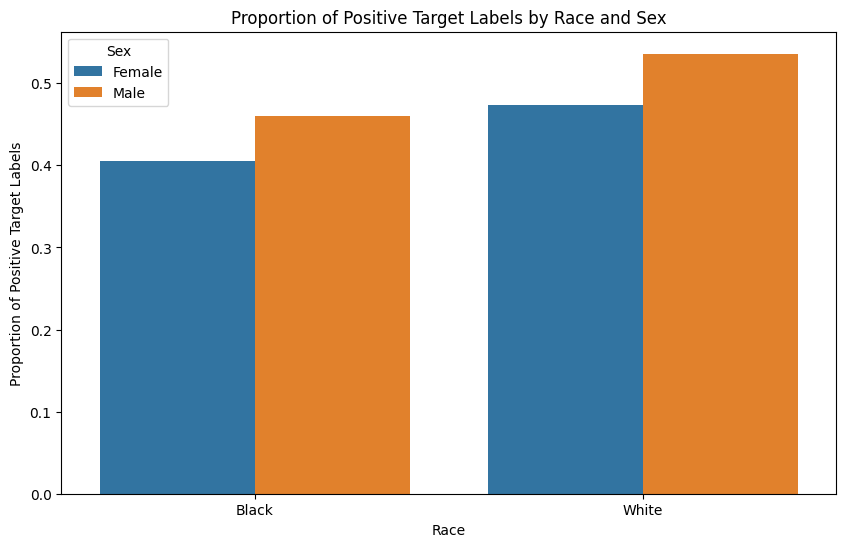

In [6]:
df = pd.DataFrame(X_train, columns = features_to_use)
df["RACE"] = group_train
df["label"] = y_train

num_individuals = len(df)
print(f"Number of individuals in the data: {num_individuals}\n")

proportion_target_1 = df['label'].mean()
print(f"Proportion of individuals with target label equal to 1: {proportion_target_1:.2f}\n")

df = df[df["RACE"].isin([1, 2])]
df["RACE"] = df["RACE"].map({1: "White", 2: "Black"})
df["SEX"] = df["SEX"].map({1: "Male", 2: "Female"})

group_counts = df['RACE'].value_counts()
print("Number of individuals in each group:")
display(group_counts.to_frame(name='count'))

group_proportion = df.groupby('RACE')['label'].mean()
print("Proportion of positive target labels by race:")
display(group_proportion.to_frame(name='Employment Proportion'))

intersectional_proportion = df.groupby(['RACE', 'SEX'])['label'].mean().unstack()
print("Proportion of positive target labels by race and sex:")
display(intersectional_proportion)

intersectional_proportion = intersectional_proportion.reset_index().melt(id_vars='RACE', value_name='proportion')

plt.figure(figsize=(10, 6))
sns.barplot(x='RACE', y='proportion', hue='SEX', data=intersectional_proportion)
plt.xlabel('Race')
plt.ylabel('Proportion of Positive Target Labels')
plt.title('Proportion of Positive Target Labels by Race and Sex')
plt.legend(title='Sex')
plt.show()

As we can see, there are 44,742 people in the dataset, 38,951 of which are White and 1,264 of which are Black. Overall, exactly half of the people are employed, and the employment proportions are 50.47% for White individuals and 43.43% for Black individuals. For both groups, the proportion of women who are employed is lower than the proportion men with 53.60% of White men employed compared to 47.35% of White women and 46.02% of Black men compared to 40.57% of Black women. The gaps between groups in interesting and illuminates the potential racial and sex-based biases in employment in Colorado.

# Model Training

Next we will train a model on the training data and evaluate it on the test data. We will use a logistic regression model, but we are interested in the potential of polynomial features to improve to predictions. To test the effect of polynomial features we will use cross validation testing with a range of polynomial degrees. The following code does this and outputs the results.

In [7]:
warnings.filterwarnings('ignore')
degrees = range(1, 5)
tests = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    LR = LogisticRegression()
    LR.fit(X_train_poly, y_train)
    LR.score(X_train_poly, y_train)
    cv_scores = cross_val_score(LR, X_train_poly, y_train, cv = 5)
    tests.append((degree, cv_scores.mean()))

df_results = pd.DataFrame(tests, columns=["Degree", "Cross-Validation Score"])
df_results.reset_index(drop=True, inplace=True)
display(df_results)

,Degree,Cross-Validation Score
0,1,0.787962
1,2,0.815163
2,3,0.814380
3,4,0.758460


As we can see, the Logistic Regression with degree of 2 performs the best, closely followed by degree 3. Given this we will use degree 2 for the rest of the analysis. The following code fits a degree 2 logistic regression model on the training data and evaluates it on the test data, outputting the accuracy.

In [8]:
model = make_pipeline(PolynomialFeatures(2), LogisticRegression())
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
print(f"Accuracy: {(y_hat == y_test).mean()}")

Accuracy: 0.8146790631146076


As we can see, the model has an accuracy of 0.815 which is very similar to the cross validation results. This is a good sign that the model is generalizing well to the test data.

# Bias Audit

The next step is to audit the results for bias. The first step is to understand the PPV and FPR rates for the overall model so that we can compare those to the rates for each group. The following code does this.

In [9]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()

ppv = tp / (tp + fp)
print(f"Positive Predictive Value (PPV): {ppv:.2f}")

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
print(f"False Positive Rate (FPR): {fpr:.2f}")
print(f"False Negative Rate (FNR): {fnr:.2f}")

Positive Predictive Value (PPV): 0.78
False Positive Rate (FPR): 0.25
False Negative Rate (FNR): 0.12


As we can see, the overall model has a PPV of 0.78, a FPR of 0.25, and a FNR of 0.12, along with the aforementioned accuracy of 0.82. Next we will calculate these metrics for each group. The following code does this.

In [10]:
print(f"Accuracy for White Individuals {(y_hat == y_test)[group_test == 1].mean()}")
print(f"Accuracy for Black Individuals {(y_hat == y_test)[group_test == 2].mean()}")

Accuracy for White Individuals 0.8162256769278287
Accuracy for Black Individuals 0.756578947368421


These results show a small difference between groups. While the accuracy for White individuals is almost exactly in line with the overall model, the accuracy for Black individuals is 6 points lower. Statistical tests would be needed to determine if this difference is statistically significant, but these results suggest that the model may be biased against Black individuals.

Next we will calculate the PPV, FPR, and FNR for each group. The following code does this.

In [11]:
X_test_df = pd.DataFrame(X_test, columns=features_to_use)
X_test_df["Race"] = group_test
X_test_df["Employment Prediction"] = y_hat
X_test_df["Employment Actual"] = y_test
X_test_df = X_test_df[X_test_df["Race"].isin([1, 2])]
X_test_df["Race"] = X_test_df["Race"].map({1: "White", 2: "Black"})

X_test_df_white = X_test_df[X_test_df["Race"] == "White"]
X_test_df_black = X_test_df[X_test_df["Race"] == "Black"]

y_test_white = X_test_df_white["Employment Actual"]
y_hat_white = X_test_df_white["Employment Prediction"]
y_test_black = X_test_df_black["Employment Actual"]
y_hat_black = X_test_df_black["Employment Prediction"]

tn_white, fp_white, fn_white, tp_white = confusion_matrix(y_test_white, y_hat_white).ravel()
tn_black, fp_black, fn_black, tp_black = confusion_matrix(y_test_black, y_hat_black).ravel()

ppv_white = tp_white / (tp_white + fp_white)
ppv_black = tp_black / (tp_black + fp_black)
print(f"Positive Predictive Value (PPV) for White Individuals: {ppv_white:.2f}")
print(f"Positive Predictive Value (PPV) for Black Individuals: {ppv_black:.2f}\n")

fpr_white = fp_white / (fp_white + tn_white)
fnr_white = fn_white / (fn_white + tp_white)
fpr_black = fp_black / (fp_black + tn_black)
fnr_black = fn_black / (fn_black + tp_black)
print(f"False Positive Rate (FPR) for White Individuals: {fpr_white:.2f}")
print(f"False Negative Rate (FNR) for White Individuals: {fnr_white:.2f}")
print(f"False Positive Rate (FPR) for Black Individuals: {fpr_black:.2f}")
print(f"False Negative Rate (FNR) for Black Individuals: {fnr_black:.2f}")

Positive Predictive Value (PPV) for White Individuals: 0.78
Positive Predictive Value (PPV) for Black Individuals: 0.66

False Positive Rate (FPR) for White Individuals: 0.25
False Negative Rate (FNR) for White Individuals: 0.12
False Positive Rate (FPR) for Black Individuals: 0.28
False Negative Rate (FNR) for Black Individuals: 0.20


As we can see, the PPV for White individuals is 0.78 and the PPV for Black individuals is 0.66. The FPR for White individuals is 0.25 and the FPR for Black individuals is 0.28. The FNR for White individuals is 0.12 and the FNR for Black individuals is 0.20. These results suggest that the model is biased against Black individuals, with a lower PPV and higher FNR compared to White individuals.

We next want to determine if the model is approximately calibrated. To do this we will check if the predicted probabilities match and don't depend on group membership. The following code does this.

In [21]:
calibration_white = X_test_df_white.groupby("Employment Prediction")["Employment Actual"].mean()
calibration_black = X_test_df_black.groupby("Employment Prediction")["Employment Actual"].mean()
calibration_white.columns = ["Employment Prediction", "White"]
calibration_black.columns = ["Employment Prediction", "Black"]
calibration_combined = pd.merge(calibration_white, calibration_black, on="Employment Prediction", how="outer")
calibration_combined.columns = ["Employment Actual - White", "Employment Actual - Black"]
display(calibration_combined)

print(f"Predicted Employement Proportion (White): {y_hat_white.mean():.2f}")
print(f"Predicted Employement Proportion (Black): {y_hat_black.mean():.2f}")

,Employment Actual - White,Employment Actual - Black
Employment Prediction,,
False,0.137581,0.154839
True,0.781867,0.664430


Predicted Employement Proportion (White): 0.57
Predicted Employement Proportion (Black): 0.49


Here, we see that the model is not perfectly calibrated, and that, given a True prediction, it is more accurate for White individuals than Black individuals. This means that the model is not approximately calibrated and is likely biased against Black individuals.

The next question relates to error rate balance. Once again, we would need statistical significance tests to determine if the differences are significant, but the previous FPR and FNR results suggest that the model is somewhat biased against Black individuals with an 8 percentage point higher false negative rate. That said, Black individuals also have a 3 percentage point higher false positive rate, so the overall effect is unclear.

Finally, we want to look at statistical parity. The previous results demonstrate that this is not satisfied as the positive prediction rate for White individuals is 8 percentage points higher than that of Black individuals. This suggests that the model is biased against Black individuals.

The final step is to look at the feasible FNR and FPR rates to determine the ceiling for fairness of this model. The following code calculates and plots the results.

Prevalence for White individuals: 0.51
Prevalence for Black individuals: 0.40


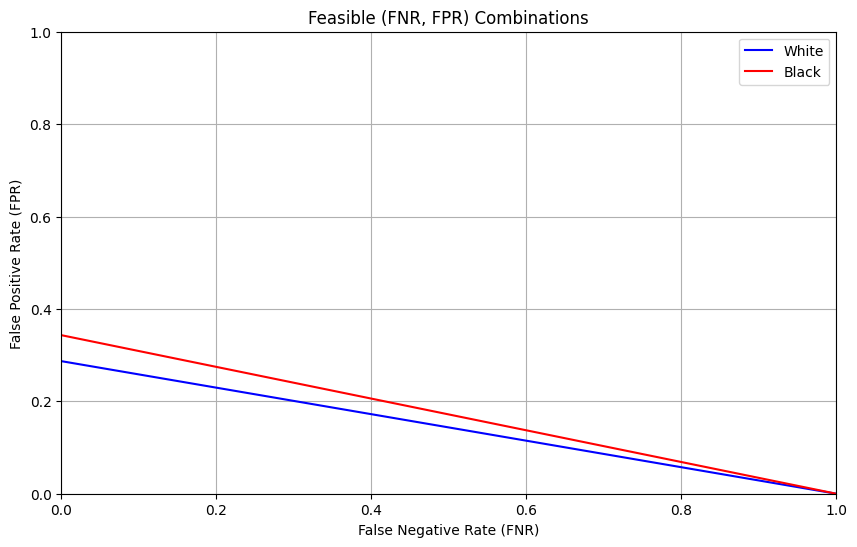

In [22]:
prevalence_white = y_test_white.mean()
prevalence_black = y_test_black.mean()

print(f"Prevalence for White individuals: {prevalence_white:.2f}")
print(f"Prevalence for Black individuals: {prevalence_black:.2f}")

desired_ppv_white = ppv_white
desired_ppv_black = ppv_black

fnr_values = np.linspace(0, 1, 100)

fpr_white = (prevalence_white / (1 - prevalence_white))*((1 - desired_ppv_white) / desired_ppv_white) * (1 - fnr_values)
fpr_black = (prevalence_black / (1 - prevalence_black))*((1 - desired_ppv_black) / desired_ppv_black) * (1 - fnr_values)

plt.figure(figsize=(10, 6))
plt.plot(fnr_values, fpr_white, label='White', color='blue')
plt.plot(fnr_values, fpr_black, label='Black', color='red')
plt.xlabel('False Negative Rate (FNR)')
plt.ylabel('False Positive Rate (FPR)')
plt.title('Feasible (FNR, FPR) Combinations')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

Holding the prevalence and PPV values fixed at their observed values, in order for false positive rates to be equal between groups, the false negative rate for both groups would have to be 1. This is obviously not desirable because it would mean that the model is not predicting any positive outcomes. This demonstrates the tradeoff between error rate ballance and positive predictive value in models, as you can't have both.

# Discussion
Banks trying to determine whether to offer loans could stand to benefit from a system that predicts employment status. Employed individuals are much more likely to pay back their loans since they have a steady income, so if a bank could predict whether an individual is employed that would help simplify their loaning decisions.

The bias audit illuminates that models based on the data available can easily become racially biased, favoring White people over their Black counterparts. Implementing such a model would greatly disadvantage Black individuals causing the unfair system to be perpetuated. This is a clear example of how machine learning models can perpetuate and exacerbate existing biases in society.

This model definitely displays problematic bias since it is biased against Black individuals. It fails error rate balance as well as sufficiency, calibration, and statistical parity as discussed above.

There are other potential problems associated with deploying such a model. As we saw in the brief intersectional analysis, the employment rates are also different between sexes. This means that the model could also be biased against certain sexes in addition to races and likely other groups as well. There is so much bias in society already so by using past data that reflects this, machine learning models can easily become biased in the same ways, perpetuating the problems.